# **IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT**

In [51]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}



In [52]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

## **GPT ARCHITECTURE PART 1: DUMMY GPT MODEL CLASS**

Step 1: Use a placeholder for TransformerBlock

Step 2: Use a placeholder for LayerNorm

In [53]:
import torch
import torch.nn as nn

# ===============================
# DummyGPTModel — A minimal GPT-like model structure
# ===============================
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        """
        Initialize the DummyGPTModel using the given configuration dictionary.

        Args:
            cfg (dict): A configuration dictionary containing model hyperparameters:
                - "vocab_size": Size of the token vocabulary.
                - "emb_dim": Dimensionality of token and positional embeddings.
                - "context_length": Maximum sequence length (number of positions).
                - "drop_rate": Dropout probability for embeddings.
                - "n_layers": Number of Transformer blocks.
        """
        super().__init__()

        # Embedding layer for tokens (converts token IDs into embedding vectors)
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])

        # Embedding layer for positional encodings (represents token position in sequence)
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        # Dropout layer applied after combining token and positional embeddings
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # A stack of "Transformer blocks" — here they are dummy placeholders
        # Each block would normally contain self-attention + feedforward layers.
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # A final normalization layer (placeholder)
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])

        # Output layer that maps from embedding dimension to vocabulary size
        # Used to generate logits for each token in the vocabulary.
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        """
        Forward pass of the DummyGPTModel.

        Args:
            in_idx (torch.Tensor): Tensor of token indices with shape (batch_size, seq_len)

        Returns:
            logits (torch.Tensor): Output predictions (unnormalized probabilities)
                                   of shape (batch_size, seq_len, vocab_size)
        """
        # Extract batch size and sequence length from input
        batch_size, seq_len = in_idx.shape

        # Token embeddings: Convert token IDs to embedding vectors
        tok_embeds = self.tok_emb(in_idx)

        # Positional embeddings: Create embeddings for each position in the sequence
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        # Combine token embeddings with positional embeddings (broadcasting adds position info)
        x = tok_embeds + pos_embeds

        # Apply dropout regularization
        x = self.drop_emb(x)

        # Pass through a series of Transformer blocks (here, they do nothing)
        x = self.trf_blocks(x)

        # Apply final normalization (dummy layer)
        x = self.final_norm(x)

        # Compute output logits for each token position
        logits = self.out_head(x)

        return logits


# ===============================
# DummyTransformerBlock — Placeholder for a real Transformer block
# ===============================
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        """
        Placeholder Transformer block.
        In a real model, this would include:
            - Multi-head self-attention
            - Feed-forward neural network
            - Layer normalization
            - Residual connections
        """
        super().__init__()
        # No real operations here — just a placeholder for architecture structure

    def forward(self, x):
        """
        Forward pass through the dummy Transformer block.
        Simply returns the input tensor unchanged.
        """
        return x


# ===============================
# DummyLayerNorm — Placeholder for Layer Normalization
# ===============================
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        """
        Dummy LayerNorm initialization.
        In a real implementation, this would compute normalization over features.

        Args:
            normalized_shape (int): Number of features in the input tensor to normalize.
            eps (float): Small constant added to denominator for numerical stability.
        """
        super().__init__()
        # Placeholder — does not actually normalize the input

    def forward(self, x):
        """
        Forward pass through the dummy normalization layer.
        Simply returns the input tensor unchanged.
        """
        return x


The DummyGPTModel class in this code defines a simplified version of a GPT-like model using
PyTorch's neural network module (nn.Module).

The model architecture in the
DummyGPTModel class consists of token and positional embeddings, dropout, a series of
transformer blocks (DummyTransformerBlock), a final layer normalization
(DummyLayerNorm), and a linear output layer (out_head).

The configuration is passed in via
a Python dictionary, for instance, the GPT_CONFIG_124M dictionary we created earlier.

The forward method describes the data flow through the model: it computes token and
positional embeddings for the input indices, applies dropout, processes the data through
the transformer blocks, applies normalization, and finally produces logits with the linear
output layer.

The code above is already functional, as we will see later in this section after we prepare
the input data.

However, for now, note in the code above that we have used placeholders
(DummyLayerNorm and DummyTransformerBlock) for the transformer block and layer
normalization, which we will develop in later sections


Next, we will prepare the input data and initialize a new GPT model to illustrate its
usage.

### **STEP 1: TOKENIZATION**

In [54]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


### **STEP 2: CREATE AN INSTANCE OF DUMMYGPTMODEL**

In [55]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


The output tensor has two rows corresponding to the two text samples. Each text sample
consists of 4 tokens; each token is a 50,257-dimensional vector, which matches the size of
the tokenizer's vocabulary.


The embedding has 50,257 dimensions because each of these dimensions refers to a
unique token in the vocabulary. At the end of this chapter, when we implement the
postprocessing code, we will convert these 50,257-dimensional vectors back into token IDs,
which we can then decode into words.

Now that we have taken a top-down look at the GPT architecture and its in- and outputs,
we will code the individual placeholders in the upcoming sections, starting with the real
layer normalization class that will replace the DummyLayerNorm in the previous code.

## **GPT ARCHITECTURE PART 2: LAYER NORMALIZATION**

#### **Explanation with a simple example**

In [56]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) #A
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


The neural network layer we have coded consists of a Linear layer followed by a non-linear
activation function, ReLU (short for Rectified Linear Unit), which is a standard activation
function in neural networks.

If you are unfamiliar with ReLU, it simply thresholds negative
inputs to 0, ensuring that a layer outputs only positive values, which explains why the
resulting layer output does not contain any negative values.

(Note that we will use another,
more sophisticated activation function in GPT, which we will introduce in the next section).


Before we apply layer normalization to these outputs, let's examine the mean and
variance

In [57]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


The first row in the mean tensor above contains the mean value for the first input row, and
the second output row contains the mean for the second input row.

Using keepdim=True in operations like mean or variance calculation ensures that the
output tensor retains the same number of dimensions as the input tensor, even though the
operation reduces the tensor along the dimension specified via dim.

For instance, without
keepdim=True, the returned mean tensor would be a 2-dimensional vector [0.1324,
0.2170] instead of a 2×1-dimensional matrix [[0.1324], [0.2170]].


For a 2D tensor (like a matrix), using dim=-1 for operations such as
mean or variance calculation is the same as using dim=1.

This is because -1 refers to the
tensor's last dimension, which corresponds to the columns in a 2D tensor.

Later, when
adding layer normalization to the GPT model, which produces 3D tensors with shape
[batch_size, num_tokens, embedding_size], we can still use dim=-1 for normalization
across the last dimension, avoiding a change from dim=1 to dim=2.

Next, let us apply layer normalization to the layer outputs we obtained earlier. The
operation consists of subtracting the mean and dividing by the square root of the variance
(also known as standard deviation)

In [58]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Note that the value 2.9802e-08 in the output tensor is the scientific notation for 2.9802 ×
10-8, which is 0.0000000298 in decimal form. This value is very close to 0, but it is not
exactly 0 due to small numerical errors that can accumulate because of the finite precision
with which computers represent numbers.

To improve readability, we can also turn off the scientific notation when printing tensor
values by setting sci_mode to False

In [59]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Let's now encapsulate this process in a PyTorch module that we can use in the GPT
model later

In [60]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

This specific implementation of layer Normalization operates on the last dimension of the
input tensor x, which represents the embedding dimension (emb_dim).

The variable eps is a
small constant (epsilon) added to the variance to prevent division by zero during
normalization.

The scale and shift are two trainable parameters (of the same dimension
as the input) that the LLM automatically adjusts during training if it is determined that
doing so would improve the model's performance on its training task.

This allows the model
to learn appropriate scaling and shifting that best suit the data it is processing.

### **A small note on biased variance**

In our variance calculation method, we have opted for an implementation detail by
setting unbiased=False.

For those curious about what this means, in the variance
calculation, we divide by the number of inputs n in the variance formula.

This approach does not apply Bessel's correction, which typically uses n-1 instead of n in
the denominator to adjust for bias in sample variance estimation.

This decision results in a so-called biased estimate of the variance.

For large-scale language
models (LLMs), where the embedding dimension n is significantly large, the
difference between using n and n-1 is practically negligible.

We chose this approach to ensure compatibility with the GPT-2 model's normalization layers and because it
reflects TensorFlow's default behavior, which was used to implement the original GPT2 model.


Let's now try the LayerNorm module in practice and apply it to the batch input

In [61]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


As we can see based on the results, the layer normalization code works as expected and
normalizes the values of each of the two inputs such that they have a mean of 0 and a
variance of 1

### **Why Normalization does not do negative effect?**

The Core Question

> “Layer normalization changes the output values numerically, and two same vectors can have different values after normalization at different times.
> Why doesn’t this negatively affect training globally?”

**What really happens when we normalize**

When you apply Layer Normalization, you compute
$$\text{LN}(x) = \gamma \cdot \frac{x - \mu}{\sigma + \epsilon} + \beta$$

* Here, $ \mu $ and $ \sigma $ are computed for each input sample separately.
* So yes — even if the same input vector appears at different training steps,
  its surrounding network context (weights before it, gradients, etc.) may have changed
   → which means $ x $, $\mu $, and $ \sigma $ will differ slightly.

Hence, the *numerical values* after normalization can differ over time.

But that’s *not a bug* — it’s part of what helps the model train.



**Why that’s not harmful (and actually helpful)**

Even though normalization changes numbers dynamically, training doesn’t get confused because

1. The model learns to adapt to normalization

> - LayerNorm has trainable parameters γ (scale) and β (bias).They let the network re-scale and re-shift normalized values as needed.
> - So if the network needs certain magnitude or offset to represent information,γ and β will learn to bring that back.
> - Normalization doesn’t destroy information — it just stabilizes it, then allows the network to “recover” whatever scale/offset it wants.

2. Normalization keeps the "direction" of information consistent

> - When you normalize, you change the magnitude of the activations but keep their relative direction in feature space.
> - In deep learning, the relative direction (how features vary together) is what carries information, not the absolute scale.
> - So even if the numeric values change, the pattern of information remains intact — and that’s what the next layer learns from.

3. It makes optimization more stable globally

> Without normalization, during backpropagation
> - Activations can explode or vanish (causing unstable gradients)
> - Each layer can shift its output distribution unpredictably (called *internal covariate shift*).
> - LayerNorm ensures that every layer sees inputs that are roughly **centered and scaled**, regardless of how other layers change.
> - This stability lets optimizers (like Adam) make consistent updates even when earlier weights shift slightly.
> - So even though the *numbers* change locally, the overall learning process stays stable globally.

4. Global model behavior depends on *relative changes*, not absolute values

> - Let’s think in terms of training dynamics
> - Suppose at time step T₁, a vector $ x_1 $ → normalized → $ y_1 $
> - At time step T₂, same vector (but slightly different due to learned weights) → normalized → $ y_2 $
> - Even though $ y_1 \ne y_2 $, the *entire model* (all layers, parameters, gradients) is changing together in a **coordinated way**.
> - Training doesn’t require outputs to be numerically stable — only that the optimization process is *consistent* and *gradient-friendly*.
> - The model doesn’t rely on *exact numbers*, but rather on how they change relative to the loss landscape.



**Analogy**

>Think of LayerNorm like a **thermostat** in a large system.
>
> - Even though the exact temperature readings (values) fluctuate,
> - The thermostat keeps things in a healthy range — preventing overheat or freeze,
> - So the overall system (the model) can keep working efficiently.
> - The local variations don’t harm the global function — they help maintain global *stability*.

**In short**

> LayerNorm changes local values dynamically,
> but globally it **preserves representational meaning, stabilizes optimization, and keeps gradients healthy.**
> That’s why it *helps* rather than hurts training.

### **Batch Normalization vs Layer Normalization**



| Feature                              | **Batch Normalization (BatchNorm)**                                                                | **Layer Normalization (LayerNorm)**                                                             |
| ------------------------------------ | -------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------- |
| **Normalization Scope**              | Across the **batch dimension** (mean and variance are computed for each feature across the batch). | Across the **feature dimension** (mean and variance are computed for each sample individually). |
| **Used in**                          | Common in **CNNs** and feedforward networks.                                                       | Common in **Transformers**, **RNNs**, and **language models**.                                  |
| **Dependency on Batch Size**         | Depends on batch statistics — smaller batches can make training unstable.                          | Independent of batch size — works well even with batch size = 1.                                |
| **When statistics are computed**     | During **training**, uses batch stats; during **inference**, uses running (moving average) stats.  | Uses **current input only**, both during training and inference.                                |
| **Computation axis**                 | Normalizes each feature across all samples in the batch.                                           | Normalizes all features within a single sample.                                                 |
| **Formula**                          | ( \hat{x} = \frac{x - \mu_{batch}}{\sigma_{batch} + \epsilon} )                                    | ( \hat{x} = \frac{x - \mu_{layer}}{\sigma_{layer} + \epsilon} )                                 |
| **Best suited for**                  | Vision models (CNNs), large batches.                                                               | Sequence models (Transformers, NLP), small batches, or variable-length inputs.                  |
| **Typical location in architecture** | After linear/convolutional layers.                                                                 | After linear or attention layers.                                                               |
| **Training Stability**               | Can fluctuate with batch composition.                                                              | More stable, since normalization is per sample.                                                 |
| **Example Use**                      | ResNet, EfficientNet                                                                               | GPT, BERT, Transformer                                                                          |

**Simple Intuition**

* **BatchNorm:** “I’ll normalize each feature across the whole mini-batch.”
* **LayerNorm:** “I’ll normalize all features within each training example.”


## **GPT ARCHITECTURE PART 3: FEEDFORWARD NEURAL NETWORK WITH GELU ACTIVATION**

Let's implement the GELU activation function approximation used by GPT-2

In [62]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

To get an idea of what this GELU function looks like and how it compares to the ReLU
function, let's plot these functions side by side

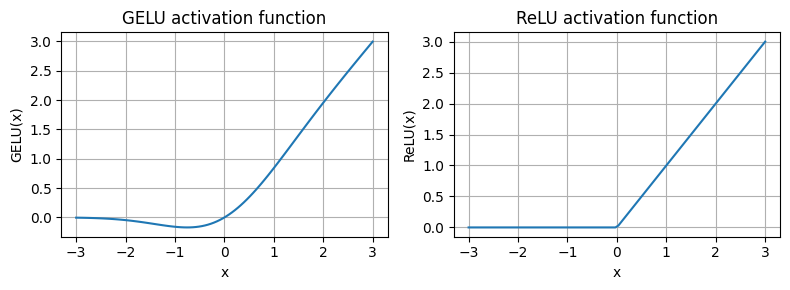

In [63]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


As we can see in the resulting plot, ReLU is a piecewise linear function that
outputs the input directly if it is positive; otherwise, it outputs zero.

GELU is a smooth, nonlinear function that approximates ReLU but with a non-zero gradient for negative values.


The smoothness of GELU, as shown in the above figure, can lead to better optimization properties
during training, as it allows for more nuanced adjustments to the model's parameters.

In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder,
especially in networks that are very deep or have complex architectures.

Moreover, unlike RELU, which outputs zero for any negative input, GELU allows for a small, non-zero output
for negative values.

This characteristic means that during the training process, neurons that
receive negative input can still contribute to the learning process, albeit to a lesser extent
than positive inputs.

Next, let's use the GELU function to implement the small neural network module,
FeedForward, that we will be using in the LLM's transformer block later:

In [64]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [65]:
print(GPT_CONFIG_124M["emb_dim"])


768


As we can see in the preceding code, the FeedForward module is a small neural network
consisting of two Linear layers and a GELU activation function.

In the 124 million parameter GPT model, it receives the input batches with tokens that have an embedding
size of 768 each via the GPT_CONFIG_124M dictionary where GPT_CONFIG_124M["emb_dim"]
= 768.


Let's use the GELU function to implement the small neural network module,
FeedForward, that we will be using in the LLM's transformer block later

In [66]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


The FeedForward module we implemented in this section plays a crucial role in enhancing
the model's ability to learn from and generalize the data.


Although the input and output dimensions of this module are the same, it internally expands the embedding dimension
into a higher-dimensional space through the first linear layer.

This expansion is followed by a non-linear GELU activation, and then a contraction back to
the original dimension with the second linear transformation.

Such a design allows for the
exploration of a richer representation space.

Moreover, the uniformity in input and output dimensions simplifies the architecture by
enabling the stacking of multiple layers, as we will do later, without the need to adjust
dimensions between them, thus making the model more scalable.

## **GPT ARCHITECTURE PART 4: SHORTCUT CONNECTIONS**

Let us see how we can add shortcut connections to the forward method

In [67]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


The code implements a deep neural network with 5 layers, each consisting of a Linear
layer and a GELU activation function.

In the forward pass, we iteratively pass the input
through the layers and optionally add the shortcut connections  if
the self.use_shortcut attribute is set to True.

Let's use this code to first initialize a neural network without shortcut connections. Here,
each layer will be initialized such that it accepts an example with 3 input values and returns
3 output values. The last layer returns a single output value

In [68]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

Next, we implement a function that computes the gradients in the the model's backward
pass

In [69]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In the preceding code, we specify a loss function that computes how close the model output
and a user-specified target (here, for simplicity, the value 0) are.

Then, when calling loss.backward(), PyTorch computes the loss gradient for each layer in the model.

We can iterate through the weight parameters via model.named_parameters().

Suppose we have a 3×3 weight parameter matrix for a given layer.

In that case, this layer will have 3×3 gradient values, and we print the mean absolute gradient of these 3×3 gradient values to
obtain a single gradient value per layer to compare the gradients between layers more
easily.

In short, the .backward() method is a convenient method in PyTorch that computes loss
gradients, which are required during model training, without implementing the math for the
gradient calculation ourselves, thereby making working with deep neural networks much
more accessible.

Let's now use the `print_gradients` function and apply it to the model without skip
connections

In [70]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


As we can see based on the output of the print_gradients function, the gradients become
smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which
is a phenomenon called the vanishing gradient problem.

Let's now instantiate a model with skip connections and see how it compares

In [71]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


As we can see, based on the output, the last layer (layers.4) still has a larger gradient
than the other layers.

However, the gradient value stabilizes as we progress towards the
first layer (layers.0) and doesn't shrink to a vanishingly small value.

In conclusion, shortcut connections are important for overcoming the limitations posed
by the vanishing gradient problem in deep neural networks.

Shortcut connections are a core building block of very large models such as LLMs, and they will help facilitate more effective
training by ensuring consistent gradient flow across layers when we train the GPT model

## **GPT ARCHITECTURE PART 5: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK**

Let us code a transformer block as follows

Step 1: Shortcut connection for attention block

Step 2:  Shortcut connection for feed forward block

Step 3: Add the original input back

In [72]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        """
        A single Transformer block that combines:
        1. Multi-Head Self-Attention
        2. Feed-Forward Network
        3. Layer Normalization
        4. Residual (skip) connections
        5. Dropout regularization

        Args:
            cfg (dict): Configuration dictionary containing:
                - emb_dim: Embedding dimension (input/output feature size)
                - context_length: Maximum number of tokens (sequence length)
                - n_heads: Number of attention heads
                - drop_rate: Dropout rate
                - qkv_bias: Whether to use bias in query/key/value projections
        """
        super().__init__()

        # Multi-Head Self-Attention layer
        # This lets each token "attend" to (look at) other tokens in the sequence
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],            # Input embedding dimension
            d_out=cfg["emb_dim"],           # Output dimension (same as input)
            context_length=cfg["context_length"],  # Sequence length (number of tokens)
            num_heads=cfg["n_heads"],       # Number of parallel attention heads
            dropout=cfg["drop_rate"],       # Dropout applied inside attention
            qkv_bias=cfg["qkv_bias"]        # Whether to use bias terms in Q, K, V projections
        )

        # Feed-forward sublayer (position-wise fully connected network)
        # Usually consists of two linear layers with a GELU/ReLU activation
        self.ff = FeedForward(cfg)

        # First Layer Normalization (applied before attention)
        self.norm1 = LayerNorm(cfg["emb_dim"])

        # Second Layer Normalization (applied before feed-forward)
        self.norm2 = LayerNorm(cfg["emb_dim"])

        # Dropout applied to residual (shortcut) connections to prevent overfitting
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        """
        Forward pass through the Transformer block.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, num_tokens, emb_dim]

        Returns:
            torch.Tensor: Output tensor of the same shape as input
        """

        # ==============================
        # 1️⃣ Attention Sub-Layer
        # ==============================

        # Save input as shortcut (for residual connection)
        shortcut = x

        # Apply layer normalization before attention
        x = self.norm1(x)

        # Apply multi-head self-attention
        # Each token attends to other tokens and aggregates contextual info
        x = self.att(x)  # Shape: [batch_size, num_tokens, emb_dim]

        # Apply dropout to attention output for regularization
        x = self.drop_shortcut(x)

        # Add the original input (residual connection)
        # Helps prevent vanishing gradients and preserves original information
        x = x + shortcut

        # ==============================
        # 2️⃣ Feed-Forward Sub-Layer
        # ==============================

        # Save input again for another residual connection
        shortcut = x

        # Apply layer normalization before feed-forward network
        x = self.norm2(x)

        # Pass through the feed-forward network
        x = self.ff(x)

        # Apply dropout to feed-forward output
        x = self.drop_shortcut(x)

        # Add the shortcut again (residual connection)
        x = x + shortcut

        # ==============================
        # 3️⃣ Output
        # ==============================

        # Return the transformed tensor (same shape as input)
        return x


The given code defines a TransformerBlock class in PyTorch that includes a multi-head
attention mechanism (MultiHeadAttention) and a feed forward network (FeedForward),
both configured based on a provided configuration dictionary (cfg), such as
GPT_CONFIG_124M

Layer normalization (LayerNorm) is applied before each of these two components, and
dropout is applied after them to regularize the model and prevent overfitting.

This is also known as Pre-LayerNorm.

Older architectures, such as the original transformer model,
applied layer normalization after the self-attention and feed-forward networks instead,
known as Post-LayerNorm, which often leads to worse training dynamics.

The class also implements the forward pass, where each component is followed by a
shortcut connection that adds the input of the block to its output. This critical feature helps
gradients flow through the network during training and improves the learning of deep
models

Using the GPT_CONFIG_124M dictionary we defined earlier, let's instantiate a transformer
block and feed it some sample data

Create sample input of shape [batch_size, num_tokens, emb_dim]

In [73]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


As we can see from the code output, the transformer block maintains the input dimensions
in its output, indicating that the transformer architecture processes sequences of data
without altering their shape throughout the network.

  
The preservation of shape throughout the transformer block architecture is not incidental
but a crucial aspect of its design.

This design enables its effective application across a wide
range of sequence-to-sequence tasks, where each output vector directly corresponds to an
input vector, maintaining a one-to-one relationship.

However, the output is a context vector
that encapsulates information from the entire input sequence.

This means that while the physical dimensions of the sequence (length and feature size)
remain unchanged as it passes through the transformer block, the content of each output
vector is re-encoded to integrate contextual information from across the entire input
sequence.

## **GPT ARCHITECTURE PART 6: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION**

The device setting will allow us to train the model on a CPU or GPU, depending on which device the input
data sits

In [74]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        """
        GPTModel — A simplified Generative Pretrained Transformer (GPT)-style model.

        This model processes sequences of token IDs and predicts the next token
        in a sequence using a stack of Transformer blocks.

        Args:
            cfg (dict): Configuration dictionary containing:
                - vocab_size: Total number of unique tokens (vocabulary size)
                - emb_dim: Embedding dimension (size of each token vector)
                - context_length: Maximum number of tokens in one input sequence
                - drop_rate: Dropout probability (for regularization)
                - n_layers: Number of stacked Transformer blocks
        """
        super().__init__()

        # ===============================
        # 1️⃣ Embedding Layers
        # ===============================

        # Token embedding: Converts token indices into continuous embedding vectors
        # Shape after embedding → [batch_size, seq_len, emb_dim]
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])

        # Positional embedding: Adds information about token positions in the sequence
        # Each position (0, 1, 2, … context_length-1) has its own embedding vector
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        # Dropout layer for regularization applied to embeddings
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # ===============================
        # 2️⃣ Transformer Blocks
        # ===============================

        # Stack of multiple Transformer blocks (each block = attention + feedforward)
        # The '*' operator unpacks the list of blocks inside nn.Sequential
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # ===============================
        # 3️⃣ Final Layers
        # ===============================

        # Layer normalization applied after all transformer layers
        # This helps stabilize the output representations
        self.final_norm = LayerNorm(cfg["emb_dim"])

        # Linear layer (output head): Maps each token’s embedding
        # to a vector of size 'vocab_size' — i.e., prediction logits for each token
        # No bias term because embedding and output projections often share weights
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        """
        Forward pass through the GPT model.

        Args:
            in_idx (torch.Tensor): Input tensor of token indices,
                                   shape [batch_size, seq_len]

        Returns:
            logits (torch.Tensor): Predicted unnormalized probabilities for each token,
                                   shape [batch_size, seq_len, vocab_size]
        """
        # Extract batch size and sequence length from the input tensor
        batch_size, seq_len = in_idx.shape

        # ===============================
        # 1️⃣ Token + Positional Embeddings
        # ===============================

        # Get token embeddings for each input token ID
        tok_embeds = self.tok_emb(in_idx)  # Shape: [batch_size, seq_len, emb_dim]

        # Create position indices (0 to seq_len-1) and get their embeddings
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        # Combine token embeddings with position embeddings
        # Adds positional information to each token representation
        x = tok_embeds + pos_embeds  # Shape: [batch_size, seq_len, emb_dim]

        # Apply dropout to prevent overfitting
        x = self.drop_emb(x)

        # ===============================
        # 2️⃣ Transformer Encoder Blocks
        # ===============================

        # Pass embeddings through the stack of Transformer blocks
        # Each block performs self-attention + feed-forward processing
        x = self.trf_blocks(x)

        # Apply final layer normalization
        x = self.final_norm(x)

        # ===============================
        # 3️⃣ Output Projection
        # ===============================

        # Project each embedding vector to vocabulary logits
        # This produces predictions for the next token at each position
        logits = self.out_head(x)  # Shape: [batch_size, seq_len, vocab_size]

        # Return logits (to be used with cross-entropy loss during training)
        return logits

  
The `__init__` constructor of this GPTModel class initializes the token and positional
embedding layers using the configurations passed in via a Python dictionary, cfg.

These
embedding layers are responsible for converting input token indices into dense vectors and
adding positional information.

   
Next, the `__init__` method creates a sequential stack of TransformerBlock modules
equal to the number of layers specified in cfg.

Following the transformer blocks, a
LayerNorm layer is applied, standardizing the outputs from the transformer blocks to
stabilize the learning process.

Finally, a linear output head without bias is defined, which
projects the transformer's output into the vocabulary space of the tokenizer to generate
logits for each token in the vocabulary.

   
The forward method takes a batch of input token indices, computes their embeddings,
applies the positional embeddings, passes the sequence through the transformer blocks,
normalizes the final output, and then computes the logits, representing the next token's
unnormalized probabilities. We will convert these logits into tokens and text outputs in the
next section.

Let's now initialize the 124 million parameter GPT model using the GPT_CONFIG_124M
dictionary we pass into the cfg parameter and feed it with the batch text input we created
at the beginning of this chapter

In [75]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


As we can see, the output tensor has the shape [2, 4, 50257], since we passed in 2 input
texts with 4 tokens each. The last dimension, 50,257, corresponds to the vocabulary size of
the tokenizer. In the next section, we will see how to convert each of these 50,257-
dimensional output vectors back into tokens.

Using the numel() method, short for "number of elements," we can collect the total
number of parameters in the model's parameter tensors

In [76]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


Earlier, we spoke of initializing a 124
million parameter GPT model, so why is the actual number of parameters 163 million, as
shown in the preceding code output?

The reason is a concept called weight tying that is used in the original GPT-2
architecture, which means that the original GPT-2 architecture is reusing the weights from
the token embedding layer in its output layer.

To understand what this means, let's take a
look at the shapes of the token embedding layer and linear output layer that we initialized
on the model via the GPTModel earlier

In [77]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


As we can see based on the print outputs, the weight tensors for both these layers have the
same shape

The token embedding and output layers are very large due to the number of rows for the
50,257 in the tokenizer's vocabulary. Let's remove the output layer parameter count from
the total GPT-2 model count according to the weight tying

In [78]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


As we can see, the model is now only 124 million parameters large, matching the original
size of the GPT-2 model.

   
Weight tying reduces the overall memory footprint and computational complexity of the
model. However, in my experience, using separate token embedding and output layers
results in better training and model performance; hence, we are using separate layers in
our GPTModel implementation. The same is true for modern LLMs.

Lastly, let us compute the memory requirements of the 163 million parameters in our
GPTModel object

In [79]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


   
In conclusion, by calculating the memory requirements for the 163 million parameters in
our GPTModel object and assuming each parameter is a 32-bit float taking up 4 bytes, we
find that the total size of the model amounts to 621.83 MB, illustrating the relatively large
storage capacity required to accommodate even relatively small LLMs.

   
In this section, we implemented the GPTModel architecture and saw that it outputs
numeric tensors of shape [batch_size, num_tokens, vocab_size]. In the next section,
we will write the code to convert these output tensors into text.

## **GPT ARCHITECTURE PART 7: GENERATING TEXT FROM OUTPUT TOKENS**

Let us implement the token-generation process as follows

Step 1: idx is a (batch, n_tokens) array of indices in the current context

Step 2: Crop current context if it exceeds the supported context size E.g., if LLM supports only 5 tokens, and the
context size is 10 then only the last 5 tokens are used as context

Step 3: Focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)

Step 4: probas has shape (batch, vocab_size)

Step 5: idx_next has shape (batch, 1)

Step 6: Append sampled index to the running sequence, where idx has shape (batch, n_tokens+1)

In [80]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

   
In the preceeding code, the generate_text_simple function, we use a softmax function to
convert the logits into a probability distribution from which we identify the position with the
highest value via torch.argmax.

The softmax function is monotonic, meaning it preserves
the order of its inputs when transformed into outputs.

So, in practice, the softmax step is
redundant since the position with the highest score in the softmax output tensor is the
same position in the logit tensor.

In other words, we could apply the torch.argmax function
to the logits tensor directly and get identical results.

However, we coded the conversion to
illustrate the full process of transforming logits to probabilities, which can add additional
intuition, such as that the model generates the most likely next token, which is known as
greedy decoding.

    
In the next chapter, when we will implement the GPT training code, we will also
introduce additional sampling techniques where we modify the softmax outputs such that
the model doesn't always select the most likely token, which introduces variability and
creativity in the generated text.

Let's now try out the generate_text_simple function with the "Hello, I am" context
as model input

First, we encode the input context into token IDs:

In [81]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


Next, we put the model into `.eval()` mode, which disables random components like
dropout, which are only used during training, and use the generate_text_simple function
on the encoded input tensor

We disable dropout since we are not training the model

In [82]:
model.eval() #A
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


Using the .decode method of the tokenizer, we can convert the IDs back into text

In [83]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


As we can see, based on the preceding output, the model generated gibberish, which is not
at all coherent text.

What happened?

The reason why the model is unable to produce coherent text is that we haven't trained it yet.

So far, we just
implemented the GPT architecture and initialized a GPT model instance with initial random
weights.

# **EVALUATING GENERATIVE TEXT MODELS**

### **GPT Model class we coded earlier**

In [84]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

### **Using GPT to generate text**

We initialize a GPT model using the code from the previous chapter

In [85]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

We reduce the context length (context_length) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens

This is so that more readers will be able to follow and execute the code examples on their laptop computer

Next, we use the `generate_text_simple` function from the previous chapter to generate text.

In addition, we define two convenience functions, `text_to_token_ids and `token_ids_to_text`, for converting between token and text representations that we use throughout this chapter

In [86]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


As we can see above, the model does not produce good text because it has not been trained yet

How do we measure or capture what "good text" is, in a numeric form, to track it during training?

The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress

The next chapters on finetuning LLMs will also introduce additional ways to measure model quality


### **Calculating the text generation loss: cross-entropy and perplexity**

Suppose we have an inputs tensor containing the token IDs for 2 training examples (rows)

Corresponding to the inputs, the targets contain the desired token IDs that we want the model to generate

Notice that the targets are the inputs shifted by 1 position, as explained in chapter 2 when we implemented the data loader

In [87]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

Feeding the inputs to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each

Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary

Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores

In [88]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


As discussed in the previous chapter, we can apply the argmax function to convert the probability scores into predicted token IDs.

The softmax function above produced a 50,257-dimensional vector for each token; the argmax function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token.

Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs:

In [89]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens.

That's because the model wasn't trained yet.

To train the model, we need to know how far it is away from the correct predictions (targets)

In [90]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


### **Cross-entropy loss**

The token probabilities corresponding to the target indices are as follows:


In [91]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([    0.0001,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0001,     0.0000])


We want to maximize all these values, bringing them close to a probability of 1.
    
In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself.

In [92]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


Next, we compute the average log probability:

In [93]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


The goal is to make this average log probability as large as possible by optimizing the model weights.

Due to the log, the largest possible value is 0, and we are currently far away from 0.

In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0.

The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning.

In [94]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


PyTorch already implements a cross_entropy function that carries out the previous steps

Before we apply the cross_entropy function, let's check the shape of the logits and targets

In [95]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


For the cross_entropy function in PyTorch, we want to flatten these tensors by combining them over the batch dimension

In [96]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize.
    
The cross_entropy function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

In [97]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


### **Perplexity**

A concept related to the cross-entropy loss is the perplexity of an LLM.

The perplexity is simply the exponential of the cross-entropy loss.

In [98]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens).

In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.
    
Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution

### **Calculating the training and validation set losses**

We use a relatively small dataset for training the LLM (in fact, only one short story)

The reasons are:

You can run the code examples in a few minutes on a laptop computer without a suitable GPU.

The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes.
    
We use a text from the public domain, which can be included in this GitHub repository without violating any usage rights or bloating the repository size.
    
For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens

At the time of this writing, the hourly cost of an 8xA100 cloud server at AWS is approximately 30 dollars.

So, via an off-the-envelope calculation, training this LLM would cost 184,320 / 8 * 30 = 690,000 dollars



In [99]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

A quick check that the text loaded ok by printing the first and last 100 words

In [100]:
# First 100 characters
print(text_data[:99])

I had always thought Jack Gisburn rather a cheap genius--though a

good fellow enough--so it was no


In [101]:
# Last 100 characters
print(text_data[-99:])

and alone, and happen once--but

there's no exterminating our kind of art."

The End of The Verdict


In [102]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20758
Tokens: 5765


With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later).

Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training.
    
For visualization purposes, the figure below assumes a max_length=6, but for the training loader, we set the max_length equal to the context length that the LLM supports.

Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position    

In [108]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [110]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with.

Llama 2 7B was trained with a batch size of 1024, for example.

An optional check that the data was loaded correctly

In [111]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


An optional check that the data was loaded correctly

In [112]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 5120
Validation tokens: 512
All tokens: 5632


Next, we implement a utility function to calculate the cross-entropy loss of a given batch.

In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader

In [113]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code.
    
Via the device setting, we ensure that the data is loaded onto the same device as the LLM model.

In [114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.970044708251953
Validation loss: 10.984174728393555


# **TRAINING LOOP FOR THE LLM**

In [115]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

Step 1: Initialize lists to track losses and tokens seen

Step 2: Start the main training loop

Step 3: Reset loss gradients from previous batch iteration

Step 4: Calculate loss gradients

Step 5: Update model weights using loss gradients

Step 6: Optional evaluation step

Step 7: Print a sample text after each epoch

In [116]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

The evaluate_model function calculates the loss over the training and
validation set while ensuring the model is in evaluation mode with gradient tracking and
dropout disabled when calculating the loss over the training and validation sets

In [117]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

The generate_and_print_sample function is a convenience function that we use to track whether the model improves during the training.

In particular, the generate_and_print_sample function takes a text snippet (start_context) as input,
converts it into token IDs, and feeds it to the LLM to generate a text sample using the
generate_text_simple function we used earlier

Let's see this all in action by training a GPTModel instance for 10 epochs using an AdamW
optimizer and the train_model_simple function we defined earlier.

In [118]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.350, Val loss 9.452
Ep 1 (Step 000005): Train loss 7.784, Val loss 7.938
Every effort moves you                                                  
Ep 2 (Step 000010): Train loss 6.496, Val loss 6.811
Ep 2 (Step 000015): Train loss 5.825, Val loss 6.393
Every effort moves you, the                                                
Ep 3 (Step 000020): Train loss 5.721, Val loss 6.334
Ep 3 (Step 000025): Train loss 5.500, Val loss 6.360
Every effort moves you, and                                                
Ep 4 (Step 000030): Train loss 5.289, Val loss 6.294
Ep 4 (Step 000035): Train loss 5.270, Val loss 6.368
Every effort moves you                              ", and, and I had been.           
Ep 5 (Step 000040): Train loss 5.140, Val loss 6.502
Ep 5 (Step 000045): Train loss 5.131, Val loss 6.384
Every effort moves you                                                  
Ep 6 (Step 000050): Train loss 4.520, Val loss 6.386
Ep 6 (Step 000055): Train loss 4

As we can see, based on the results printed during the training, the training loss improves
drastically, starting with a value of 9.781 and converging to 0.391.

The language skills of
the model have improved quite a lot. In the beginning, the model is only able to append
commas to the start context ("Every effort moves you,,,,,,,,,,,,") or repeat the
word "and".

At the end of the training, it can generate grammatically correct text.

Similar to the training set loss, we can see that the validation loss starts high (9.856)
and decreases during the training.

However, it never becomes as small as the training set
loss and remains at 6.372 after the 10th epoch.

Let's create a simple plot that shows the training and validation set losses side by side

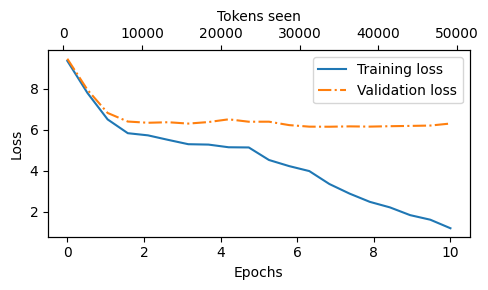

In [119]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Both the training and validation losses start to improve for the first
epoch. However, the losses start to diverge past the second epoch.

This divergence and the
fact that the validation loss is much larger than the training loss indicate that the model is
overfitting to the training data.

We can confirm that the model memorizes the training data
verbatim by searching for the generated text snippets, such as "quite insensible to the
irony" in the "The Verdict" text file.


This memorization is expected since we are working with a very, very small training
dataset and training the model for multiple epochs.

Usually, it's common to train a model
on a much, much larger dataset for only one epoch.   

## **Notes**

### Optimizers Used in LLM Training

Large Language Models (LLMs) rely on gradient-based optimization, where optimizers adjust billions of parameters to minimize the loss.
The most common optimizers are **Adam** and its improved variants.

| **Optimizer**         | **Description**                                                                                                  | **Used In**                      |
| --------------------- | ---------------------------------------------------------------------------------------------------------------- | -------------------------------- |
| **Adam**              | Adaptive Moment Estimation — combines *momentum* and *RMSProp* ideas to adapt learning rates for each parameter. | BERT, GPT-2                      |
| **AdamW**             | Adam with **decoupled weight decay**, improving generalization and training stability.                           | GPT-3, GPT-4, LLaMA              |
| **Lion**              | Lightweight optimizer using only the **sign of momentum** for updates — faster and more memory-efficient.        | Newer research (Meta, 2023–2024) |
| **Adafactor**         | Memory-efficient Adam variant — factorizes large parameter matrices.                                             | T5, PaLM                         |
| **SGD with Momentum** | Simple and stable, but converges slower in high-dimensional settings.                                            | Smaller or older models          |


**Example: AdamW Update Rule**

> The **AdamW optimizer** is a key improvement over Adam.
> It decouples *weight decay* from the gradient update, improving convergence and avoiding bias in L2 regularization.

**Update Equations**

At iteration (t)

$$ m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t $$
$$ v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 $$
$$ \hat{m}_t = \frac{m_t}{1 - \beta_1^t} $$
$$ \hat{v}*t = \frac{v_t}{1 - \beta_2^t} $$
$$ \theta*{t+1} = \theta_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} - \eta \lambda \theta_t $$



**Explanation of Terms**

| Symbol                   | Meaning                                                       |
| ------------------------ | ------------------------------------------------------------- |
| ( g_t )                  | Gradient of loss with respect to parameters at step (t)       |
| ( m_t )                  | Exponentially decaying average of past gradients (momentum)   |
| ( v_t )                  | Exponentially decaying average of past squared gradients      |
| ( \beta_1, \beta_2 )     | Hyperparameters controlling decay rates (typical: 0.9, 0.999) |
| ( \hat{m}_t, \hat{v}_t ) | Bias-corrected estimates of (m_t) and (v_t)                   |
| ( \eta )                 | Learning rate                                                 |
| ( \lambda )              | Weight decay coefficient (regularization term)                |
| ( \epsilon )             | Small constant for numerical stability                        |



**How It Works Conceptually**

1. **Compute gradient** ( g_t ) of the loss function.
2. **Update moving averages:**

   * ( m_t ): tracks gradient direction (momentum).
   * ( v_t ): tracks gradient magnitude (RMS normalization).
3. **Bias-correct** both to account for initialization effects.
4. **Update parameters:** move opposite to the gradient direction, with adaptive step size.
5. **Apply weight decay:** regularize parameters to prevent overfitting.



### Optimization Challanges

| Challenge                         | Description                                          | Mitigation                                             |
| --------------------------------- | ---------------------------------------------------- | ------------------------------------------------------ |
| **Vanishing/Exploding Gradients** | Gradients become too small/large through deep layers | LayerNorm, residuals, gradient clipping                |
| **Instability in FP16 precision** | Floating point rounding issues                       | Use BF16 or mixed-precision scaling                    |
| **Huge Memory Usage**             | Billions of parameters & optimizer states            | ZeRO optimizer, sharded training                       |
| **Slow Convergence**              | Needs trillions of tokens                            | Adaptive LR, batch normalization, large-batch training |
| **Catastrophic Forgetting**       | During fine-tuning, model forgets pretraining        | Low LR, regularization, LoRA adapters                  |


### **Learning Rate Schedules**

The **learning rate (LR)** controls *how big a step* the optimizer takes when updating weights.
If the step is **too big → unstable / divergence**,
if **too small → slow learning**.

So, instead of keeping it constant, LLMs **change it gradually during training** — this is called a **learning rate schedule**.

---

Common Learning Rate Schedules

| **Schedule**              | **What It Does**                                                                                                       | **How It Helps**                                                    | **Used In**                |
| ------------------------- | ---------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------- | -------------------------- |
| **Warmup + Cosine Decay** | Start with a small LR <br> (warmup), then slowly<br> increase, and finally<br> decrease in a smooth<br> wave-like curve <br>(cosine shape). | Prevents instability at the<br> start and fine-tunes slowly <br>at the end. | GPT, LLaMA                 |
| **Linear Decay**          | Increases LR during<br> warmup, then gradually<br> decreases it linearly to <br>zero.                                              | Simple and stable for<br> most models.                                  | BERT, RoBERTa              |
| **Step Decay**            | Keeps LR constant for<br> a few epochs, then<br> suddenly reduces it<br> (like steps).                                             | Older technique, less smooth.                                       | Early deep learning models |


**Why “Warmup”?**


At the very beginning of training

* The model’s weights are random.
* Gradients (the learning signals) can be **unstable or huge**.

If you start with a large learning rate, these large gradients can **blow up the weights** → training fails.

So, we **“warm up”** by

* starting with a very small learning rate,
* gradually increasing it for the first few thousand steps,
* then switching to a decay schedule.

Think of it like

> 🚗 “Don’t go from 0 to 100 immediately — start slow, then accelerate.”



### Gradient Optimization Techniques

Training a massive model like GPT means working with **billions of parameters** and **huge gradients**.
So researchers use a few **tricks** to make training stable, efficient, and possible even with limited GPU memory.

**Key Techniques Explained Simply**

| **Technique**                                  | **What It Means (Beginner Explanation)**                                                                                                          | **Why It’s Used**                                                              |
| ---------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ |
| **Gradient Clipping**                          | If the gradient (update signal) is too large,<br> we “clip” or limit its size.                                                                        | Prevents the model from making wild,<br> unstable updates (“exploding gradients”). |
| **Gradient Accumulation**                      | Instead of using a huge batch at once <br>(which doesn’t fit in memory), we process<br> several small batches, sum their gradients, <br>and then update once. | Simulates large-batch training even on smaller<br> GPUs.                           |
| **Mixed Precision Training (FP16 / BF16)**     | Uses smaller floating-point numbers <br>(16-bit instead of 32-bit) for faster math <br>and less memory use — while keeping<br> accuracy.                      | Makes training faster and reduces GPU memory<br> use.                              |
| **Distributed Gradient Averaging (DDP)**       | When training on multiple GPUs or <br> machines, each computes its gradients,<br> and then all gradients are averaged <br>together.                            | Ensures all GPUs learn the same way<br> (synchronized training).                   |
| **ZeRO Optimizer (Zero Redundancy Optimizer)** | Splits up the optimizer’s big memory states<br> across GPUs instead of duplicating them.                                                              | Allows models with *trillions* of parameters to fit <br>in GPU memory.             |
| **Checkpointing (Activation Recomputation)**   | Instead of saving every activation in<br> memory, we recompute some of them <br>during backpropagation.                                                   | Saves memory — trades a bit of speed for<br> huge memory savings.                  |



**Simple Real-World Analogy**

| Technique             | Analogy                                                                          |
| --------------------- | -------------------------------------------------------------------------------- |
| Gradient Clipping     | Like limiting the maximum speed of a car to avoid crashing.                      |
| Gradient Accumulation | Like carrying 10 small boxes one by one instead of 1 huge box.                   |
| Mixed Precision       | Like using lighter materials that still get the job done.                        |
| DDP                   | Like multiple chefs cooking the same recipe and comparing notes to stay in sync. |
| ZeRO                  | Like dividing grocery bags among friends so no one carries too much.             |
| Checkpointing         | Like not remembering every step, but redoing a few to save brain space.          |


### Advanced Optimization Techniques (Modern Trends)

1. **LoRA (Low-Rank Adaptation)**

What It Is

> LoRA is a clever way to fine-tune large language models **without changing all of their billions of weights**.
> Instead, it adds a few **tiny trainable layers** (small matrices) inside the model.

So during fine-tuning:=

* The **main model stays frozen** (unchanged)
* Only the **small LoRA layers** are trained

Intuition

> Think of the big model as a **frozen brain**, and LoRA as adding a **small patch of new neurons** that learn the new skill.

Why It’s Useful

* Much faster fine-tuning
* Needs **way less GPU memory**
* You can train multiple versions (for different tasks) cheaply

Example
> Fine-tune a 70B model for a medical chatbot — instead of training all 70B parameters, you just train maybe 10M LoRA parameters.

Used In

> LLaMA, Falcon, Mistral, and most modern instruction-tuned or domain-specific LLMs.

---
2. **QLoRA (Quantized LoRA)**

What It Is:

> An improved version of LoRA that uses **quantization** — storing model weights in **4-bit numbers** (instead of 16-bit or 32-bit).
> That’s a massive compression
> 32-bit → 4-bit = 8× smaller memory use

QLoRA fine-tunes these **compressed models** using the same LoRA idea.

Intuition

> Imagine fitting a huge encyclopedia into your phone by **compressing** it — but you can still read and update parts of it efficiently.

Why It’s Useful

* Lets you fine-tune **very large models (65B+) on a single GPU**.
* Retains almost the same accuracy as full-precision training.
* Ideal for researchers or smaller teams with limited hardware.

Example:
> Fine-tuning a 33B model on a **24GB RTX 4090** GPU — possible with QLoRA!

Used In:

> Alpaca, Vicuna, and many open-source fine-tuned LLMs.

---

3. **PEFT (Parameter-Efficient Fine-Tuning)**

What It Is

> PEFT is a **general family** of methods (including LoRA, Prefix-Tuning, Adapter-Tuning, etc.)
> The goal: fine-tune large models by **updating only a small subset of parameters**.

Intuition:

> Instead of repainting an entire building (full fine-tuning), you **repaint only a few key walls** (PEFT).
> The rest stays as it is.

Why It’s Useful

* Reduces training time ⏱️
* Requires much less memory 💾
* Keeps the original knowledge intact
* Easy to switch between multiple tasks quickly

Example

A base LLM can be fine-tuned into
* A medical assistant
* A legal assistant
* A coding helper
  Each fine-tune just adds a **small PEFT adapter**, not a whole new model.

Used In

> All efficient fine-tuning libraries (Hugging Face PEFT, LoRA, QLoRA, Prefix Tuning).

---

4. **DPO / PPO (for Alignment via RLHF)**

> These are **optimization methods used during alignment** — when the model is trained to **follow human preferences** (this is part of **RLHF – Reinforcement Learning from Human Feedback**).

Step-by-Step Idea

1. You first train a model to predict the next token (pretraining).
2. Then fine-tune it to follow instructions (SFT).
3. Finally, you *align* it using feedback from humans — this is where **PPO or DPO** comes in.

---

PPO — *Proximal Policy Optimization*

* Comes from reinforcement learning.
* The model is treated like a “policy” that chooses words.
* It’s rewarded for producing responses humans prefer.
* The **KL penalty** ensures it doesn’t drift too far from the base model.

Analogy

> Teaching a child: reward answers that sound polite and correct; gently discourage wrong or rude ones.

---
DPO — *Direct Preference Optimization*

* A newer, simpler alternative to PPO.
* Trains directly on pairs of responses (good vs bad).
* No need for a separate reward model — it’s built into the math.
* Easier and more stable to train.

Analogy

> Show the model two answers — “A” and “B” — and tell it, “A is better.” The model learns to prefer answers like A in the future.



Why They Matter

* Aligns LLM behavior with **human expectations**
* Prevents harmful, rude, or irrelevant responses
* Used in models like **ChatGPT, Claude, Gemini**

---

5. **Gradient Checkpointing**

What It Is:

> A memory-saving trick used during **training very deep models** (like 100+ transformer layers).
> Normally, training stores *all intermediate activations* for backpropagation.
That’s huge — it eats tons of GPU memory.
> With **gradient checkpointing**, we:

* Save only some activations,
* Recompute the rest during backpropagation.

> This trades **extra computation** for **massive memory savings**.

Intuition

> Imagine you’re hiking a trail and forget some landmarks.
> Instead of carrying a big map (memory), you **retrace a few steps** (extra compute) to find your way back.

Why It’s Useful
* Saves **50–70% GPU memory**.
* Makes training deep transformers possible on limited hardware.
* Commonly used in GPT, LLaMA, and almost all large-scale models.




# **DECODING STRATEGIES TO CONTROL RANDOMNESS**

First, we briefly revisit the generate_text_simple function
from the previous chapter that we used inside the generate_and_print_sample earlier in
this chapter.

Then, we will cover two techniques, temperature scaling, and top-k sampling,
to improve this function.

We begin by transferring the model back from the GPU to the CPU since inference with a
relatively small model does not require a GPU. Also, after training, we put the model into
evaluation model to turn off random components such as dropout

In [120]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

Next, we plug the GPTModel instance (model) into the generate_text_simple function,
which uses the LLM to generate one token at a time

In [121]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know, I seemed to see a smile behind his close




"--for it was not till after that


## **DECODING STRATEGY 1: TEMPERATURE SCALING**

Previously, inside the generate_text_simple function, we always sampled the token
with the highest probability as the next token using torch.argmax, also known as greedy
decoding.

To generate text with more variety, we can replace the argmax with a function
that samples from a probability distribution (here, the probability scores the LLM generates
for each vocabulary entry at each token generation step).

To illustrate the probabilistic sampling with a concrete example, let's briefly discuss the
next-token generation process using a very small vocabulary for illustration purposes

In [122]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

Next, assume the LLM is given the start context "every effort moves you" and
generates the following next-token logits

In [123]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

As discussed in the previous chapter, inside the generate_text_simple, we convert the
logits into probabilities via the softmax function and obtain the token ID corresponding the
generated token via the argmax function, which we can then map back into text via the
inverse vocabulary

In [124]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


To implement a probabilistic sampling process, we can now replace the argmax with the
multinomial function in PyTorch

In [125]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


The printed output is "forward" just like before. What happened? The multinomial
function samples the next token proportional to its probability score.

In other words,
"forward" is still the most likely token and will be selected by multinomial most of the
time but not all the time.

To illustrate this, let's implement a function that repeats this
sampling 1000 times

In [126]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


As we can see based on the output, the word "forward" is sampled most of the time (582
out of 1000 times), but other tokens such as "closer", "inches", and "toward" will also
be sampled some of the time.

This means that if we replaced the argmax function with the
multinomial function inside the generate_and_print_sample function, the LLM would
sometimes generate texts such as "every effort moves you toward", "every effort
moves you inches", and "every effort moves you closer" instead of "every effort
moves you forward".

We can further control the distribution and selection process via a concept called
temperature scaling, where temperature scaling is just a fancy description for dividing the
logits by a number greater than 0

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and Temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions.

Let's illustrate this by plotting the original probabilities alongside
probabilities scaled with different temperature values

In [127]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

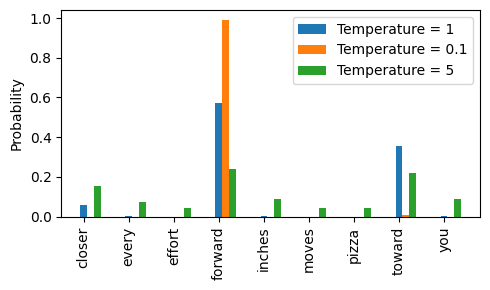

In [128]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

A temperature of 1 divides the logits by 1 before passing them to the softmax function to
compute the probability scores.

In other words, using a temperature of 1 is the same as not
using any temperature scaling.

In this case, the tokens are selected with a probability equal
to the original softmax probability scores via the multinomial sampling function in PyTorch.    

Applying very small temperatures, such as 0.1, will
result in sharper distributions such that the behavior of the multinomial function selects
the most likely token (here: "forward") almost 100% of the time, approaching the
behavior of the argmax function.

Vice versa, a temperature of 5 results in a more uniform
distribution where other tokens are selected more often.

This can add more variety to the
generated texts but also more often results in nonsensical text.

For example, using the
temperature of 5 results in texts such as "every effort moves you pizza" about 4% of
the time.

## **DECODING STRATEGY 2: Top-k sampling**

In the previous section, we implemented a probabilistic sampling approach coupled with
temperature scaling to increase the diversity of the outputs.

We saw that higher
temperature values result in more uniformly distributed next-token probabilities, which
result in more diverse outputs as it reduces the likelihood of the model repeatedly selecting
the most probable token.

This method allows for exploring less likely but potentially more
interesting and creative paths in the generation process.

However, One downside of this
approach is that it sometimes leads to grammatically incorrect or completely nonsensical
outputs such as "every effort moves you pizza".

In this section, we introduce another concept called top-k sampling, which, when
combined with probabilistic sampling and temperature scaling, can improve the text
generation results.

In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens
and exclude all other tokens from the selection process by masking their probability scores.

In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


Subsequently, we apply PyTorch's where function to set the logit values of tokens that are
below the lowest logit value within our top-3 selection to negative infinity (-inf).

In [ ]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


Lastly, let's apply the softmax function to turn these into next-token probabilities:

In [ ]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## **Merge Temperature Scaling and Top-k sampling**

We can now apply the temperature scaling and multinomial function for probabilistic
sampling introduced in the previous section to select the next token among these 3 nonzero probability scores to generate the next token. We do this in the next section by
modifying the text generation function.

The previous two subsections introduced two concepts to increase the diversity of LLMgenerated text: temperature sampling and top-k sampling. In this section, we combine and
add these concepts to modify the generate_simple function we used to generate text via
the LLM earlier, creating a new generate function

Step 1: For-loop is the same as before: Get logits, and only focus on last time step

Step 2: In this new section, we filter logits with top_k sampling

Step 3: This is the new section where we apply temperature scaling
    
Step 4: Carry out greedy next-token selection as before when temperature scaling is disabled

Step 5: Stop generating early if end-of-sequence token is encountered and eos_id is specified

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

Let's now see this new generate function in action

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


As we can see, the generated text is very different from the one we previously generated
via the generate_simple function at the beginning of section 5.3 ("Every effort moves
you know," was one of the axioms he laid...!"), which was a memorized passage
from the training set.

# **Decoding Strategies in LLMs**


When a **Large Language Model (LLM)** like GPT or LLaMA generates text, it predicts
*“What’s the most likely next word given all previous words?”*
<br>
But there’s a catch
LLMs don’t just output *one* word; they output a **probability distribution** over thousands of possible words (tokens).

Decoding strategies control **how we choose the next word** from those probabilities.

## **What Decoding Really Means**


Imagine this

```
Input: "The cat is"
Predictions:
sleeping → 0.70
running → 0.20
eating  → 0.10
```

Now the model must decide — which one to pick?
Different decoding strategies make this choice differently.

## **Greedy Decoding**

Idea: Always pick the word with the *highest* probability.

Example:

```
sleeping (0.7) → choose “sleeping”
```

> Output: “The cat is sleeping.”

**Pros**

* Simple and very fast
* Always gives the same answer (deterministic)

**Cons**

* Can get repetitive (e.g., “the cat is sleeping sleeping sleeping…”)
* Sometimes misses better long-term options

**Use when:** you want short, factual, or code-like outputs where creativity isn’t needed.


##  **Beam Search**

**Idea:** Keep multiple possible sentences at once — not just one.

Let’s say *beam size = 3*:

* The model keeps the 3 most likely sentence paths at each step.
* It expands them, scores them, and keeps the best 3 again.
* Finally, it chooses the most likely full sentence.

**Example:**

```
Beams:
1. The cat is sleeping.
2. The cat is running fast.
3. The cat is eating fish.
```

→ Model picks the best based on total probability.

**Pros**

* More balanced and accurate than greedy
* Often gives smoother, grammatically correct text

**Cons**

* Slower (because it tries many paths)
* Still may lack creativity
* Can repeat phrases if beam size is too big

**Used in:** translation models (e.g., Google Translate), summarization.

## **Top-k Sampling**

**Idea:** Add controlled randomness.
Instead of picking *only the top token*, choose randomly from the **top k tokens**.

**Example:**
If `k = 3`

```
sleeping (0.7)
running (0.2)
eating  (0.1)
```

→ Model randomly picks one from these 3.

**Pros**

* Adds creativity and variation
* Reduces boring repetitive output

**Cons**

* Still somewhat random
* Needs tuning (too high k = chaos, too low k = boring)

**Used in:** story generation, role-playing chatbots, and poetry generation.

## **Top-p (Nucleus) Sampling**

**Idea:** Instead of a *fixed number* of words (like k), choose tokens until their **total probability ≥ p** (like 0.9).

**Example**

```
sleeping (0.7) + running (0.2) = 0.9 → pick from [sleeping, running]
```

→ Model samples from only these.

**Pros**

* Automatically adapts to context (flexible)
* Produces human-like, natural text

**Cons**

* Can still be inconsistent
* Requires good choice of p (commonly 0.9 or 0.95)

**Used in:** ChatGPT and modern conversational LLMs.

## **Temperature Sampling**

**Idea** Control how “confident” or “creative” the model is by adjusting *temperature (T)*.

* **Low T (< 1.0):** more focused and predictable
* **High T (> 1.0):** more random and creative

**Example**

```
At T = 0.5 → prefers top tokens strongly  
At T = 1.5 → explores more varied words
```

**Pros**

* Fine-tunes creativity vs accuracy
* Works great combined with Top-p or Top-k

**Cons**

* Too high T = nonsense
* Too low T = robotic text

**Used when:** you want to control tone — factual (low T), or creative (high T).

## **Typical Sampling**

**Idea:** Keeps words that are *“typical”* (close to model’s average surprise level).
Removes

* Words that are too common (boring)
* Words that are too rare (weird)

**Pros**

* Natural, balanced, less repetitive text
* Combines the best of Top-p and Temperature

**Used in** modern chatbots like GPT-3.5, GPT-4 for conversational tone.

##  **Contrastive Decoding**

**Idea:** Uses two models

* **Large model:** generates fluent text
* **Small model:** filters out generic or overconfident text

Formula
$$
\text{score}(x) = P_{large}(x) - \alpha \times P_{small}(x)
$$

**Pros**

* More factual and precise
* Avoids hallucinations and repetition

**Used in** factual Q&A, retrieval-based systems, and academic content.


## **Sampling + Re-ranking**

**Idea** Generate multiple possible outputs, then rank them with a *reward* or *critic model* (used in RLHF — Reinforcement Learning from Human Feedback).

Example

1. Generate 5 possible replies.
2. Use a separate model to score them.
3. Choose the one with the best score.

**Pros**

* Highest quality responses
* Aligns with human preferences
**Used in** ChatGPT and alignment training.

## **Quick Analogy**

Think of decoding like **ordering food from a restaurant** 🍽️:

| Strategy             | Analogy                                                                      |
| -------------------- | ---------------------------------------------------------------------------- |
| **Greedy**           | Always order your favorite dish every time.                                  |
| **Beam Search**      | Try 3 dishes, then pick the best one.                                        |
| **Top-k**            | Choose randomly from your top 3 favorites.                                   |
| **Top-p**            | Choose randomly from dishes that together make up 90% of your favorites.     |
| **Temperature**      | Higher temperature → you experiment more; lower temperature → you play safe. |
| **Typical Sampling** | You usually order something “normal” — not too basic, not too weird.         |
| **Contrastive**      | You and your friend (small model) agree on what’s good before ordering.      |
